# ISLP - Chapter 7 - Exercise 8
### Author: pzuehlke

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.nonparametric.smoothers_lowess import lowess

In [32]:
# Set styling for seaborn plots:
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)

auto = pd.read_csv("Auto.csv")
auto.dropna(inplace=True)
auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           397 non-null    float64
 1   cylinders     397 non-null    int64  
 2   displacement  397 non-null    float64
 3   horsepower    397 non-null    object 
 4   weight        397 non-null    int64  
 5   acceleration  397 non-null    float64
 6   year          397 non-null    int64  
 7   origin        397 non-null    int64  
 8   name          397 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.0+ KB


The `horsepower` variable is encoded as a string and some of the values
equal '?'. We will remove these and convert it to a numeric variable:

In [72]:
print(auto["horsepower"].unique())
auto = auto[auto["horsepower"] != '?']
auto["horsepower"] = pd.to_numeric(auto["horsepower"], errors="coerce")

[130 165 150 140 198 220 215 225 190 170 160  95  97  85  88  46  87  90
 113 200 210 193 100 105 175 153 180 110  72  86  70  76  65  69  60  80
  54 208 155 112  92 145 137 158 167  94 107 230  49  75  91 122  67  83
  78  52  61  93 148 129  96  71  98 115  53  81  79 120 152 102 108  68
  58 149  89  63  48  66 139 103 125 133 138 135 142  77  62 132  84  64
  74 116  82]


In [73]:
auto.head(10)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino
5,15.0,8,429.0,198,4341,10.0,70,1,ford galaxie 500
6,14.0,8,454.0,220,4354,9.0,70,1,chevrolet impala
7,14.0,8,440.0,215,4312,8.5,70,1,plymouth fury iii
8,14.0,8,455.0,225,4425,10.0,70,1,pontiac catalina
9,15.0,8,390.0,190,3850,8.5,70,1,amc ambassador dpl


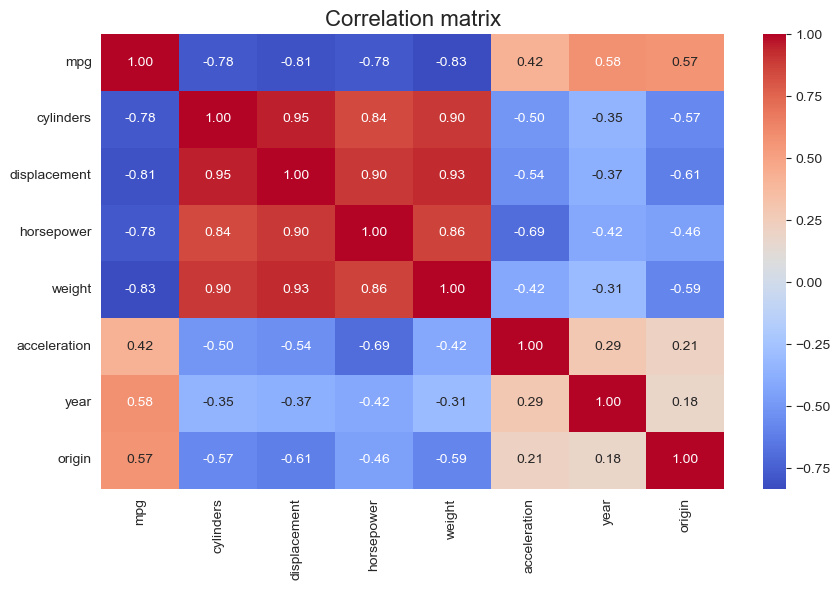

In [36]:
# Check correlation matrix for numerical features:
correlation_matrix = auto.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(9, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation matrix", fontsize=16)
plt.tight_layout()
plt.show()

We will study the relationship between `horsepower` and `mpg` using polynomial
regression. The best model will be chosen through cross-validation using
mean squared error as the metric.

In [ ]:
X = auto["horsepower"].values.reshape(-1, 1)
y = auto["mpg"].values
n = len(X)

In [97]:
# Setup for cross-validation
max_degree = 5
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Metrics storage
mse_scores = []

for degree in range(1, max_degree + 1):
    # Create pipeline with polynomial features and linear regression
    model = make_pipeline(
        PolynomialFeatures(degree=degree, include_bias=False),
        LinearRegression()
    )
    
    # Perform cross-validation with MSE
    scores = cross_val_score(model, X, y, cv=cv, scoring="neg_mean_squared_error")
    
    # Store mean MSE score (note: scores are negative because of make_scorer)
    mse_scores.append(-np.mean(scores))

best_degree_mse = np.argmin(mse_scores) + 1  # We want minimum MSE

In [98]:
print(f"{'Degree':<10}{'MSE':<12}")
for i in range(max_degree):
    degree = i + 1
    print(f"{degree:<10}{mse_scores[i]:.4f}")

print(f"Best model by MSE: degree {best_degree_mse}")

Degree    MSE         
1         24.2198
2         19.2217
3         19.2397
4         19.3682
5         18.9468
Best model by MSE: degree 5


It seems that even though the best model was found to have degree $ 5 $,
choosing degrees greater than $ 2 $ does not lead to substantial improvements in
the predictive power of the regression. However, let's use statsmodels to
perform formal hypothesis testing:

In [79]:
print("\nANOVA tests for polynomial terms:")
print("---------------------------------")
for degree in range(1, 5):
    poly_features = PolynomialFeatures(degree=degree, include_bias=True)
    X_poly_1 = poly_features.fit_transform(X)
    
    poly_features = PolynomialFeatures(degree=degree + 1, include_bias=True)
    X_poly_2 = poly_features.fit_transform(X)
    
    model1 = sm.OLS(y, X_poly_1).fit()
    model2 = sm.OLS(y, X_poly_2).fit()
    
    # Perform ANOVA test
    anova_result = sm.stats.anova_lm(model1, model2)
    print(f"Degree {degree} vs. Degree {degree + 1}:")
    print(anova_result)
    print()


ANOVA tests for polynomial terms:
---------------------------------
Degree 1 vs. Degree 2:
   df_resid          ssr  df_diff     ss_diff           F        Pr(>F)
0     390.0  9385.915872      0.0         NaN         NaN           NaN
1     389.0  7442.029412      1.0  1943.88646  101.608283  2.196340e-21

Degree 2 vs. Degree 3:
   df_resid          ssr  df_diff    ss_diff        F    Pr(>F)
0     389.0  7442.029412      0.0        NaN      NaN       NaN
1     388.0  7426.436007      1.0  15.593405  0.81469  0.367297

Degree 3 vs. Degree 4:
   df_resid          ssr  df_diff    ss_diff         F    Pr(>F)
0     388.0  7426.436007      0.0        NaN       NaN       NaN
1     387.0  7399.522632      1.0  26.913375  1.407588  0.236185

Degree 4 vs. Degree 5:
   df_resid          ssr  df_diff     ss_diff         F    Pr(>F)
0     387.0  7399.522632      0.0         NaN       NaN       NaN
1     386.0  7223.371686      1.0  176.150946  9.413092  0.002306



Our previous results are substantiated by the ANOVA tests.
A quadratic model provides a clear improvement over a linear model. Then degrees
$ 3 $ and $ 4 $ don't add much value, but surprisingly, degree $ 5 $ shows
statistically significant improvement. This suggests either:
* The relationship has a meaningful $ 5 $-th degree component.
* Or, more likely, this could be overfitting or capturing some specific pattern
  in the data that may not generalize well.

In this situation, I would tend to choose the quadratic model, even though
it has a slightly worse MSE.

Next let's use local regression with different span parameters. This time we
will use training $ R^2 $ as a metric.

In [85]:
n_folds = 5
fractions = [0.2, 0.3, 0.4, 0.5, 0.6]
kf = KFold(n_splits=n_folds, shuffle=True, random_state=0)
cv_results = {frac: [] for frac in fractions}

In [ ]:
for train_idx, test_idx in cv.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    for frac in fractions:
        # Fit local regression model on training data:
        model = lowess(y_train, X_train.flatten(), frac=frac, it=0)
        # Create interpolation function from the model:
        predictions = np.interp(X_test.flatten(), 
                                model[:, 0], 
                                model[:, 1])
        
        # Calculate R^2 on test data:
        r2 = r2_score(y_test, predictions)
        cv_results[frac].append(r2)

In [101]:
avg_r2 = {frac: np.mean(scores) for frac, scores in cv_results.items()}

for frac, r2 in avg_r2.items():
    print(f"Local regression with fraction = {frac}: average CV R^2 = {r2:.4f}")

Local regression with fraction = 0.2: average CV R^2 = 0.6858
Local regression with fraction = 0.3: average CV R^2 = 0.6880
Local regression with fraction = 0.4: average CV R^2 = 0.6843
Local regression with fraction = 0.5: average CV R^2 = 0.6817
Local regression with fraction = 0.6: average CV R^2 = 0.6799


The models seem to be roughly equivalent in explaining the variance
in the data. Let's plot the models with spans $ 0.2 $, $ 0.4 $ and $ 0.6 $:

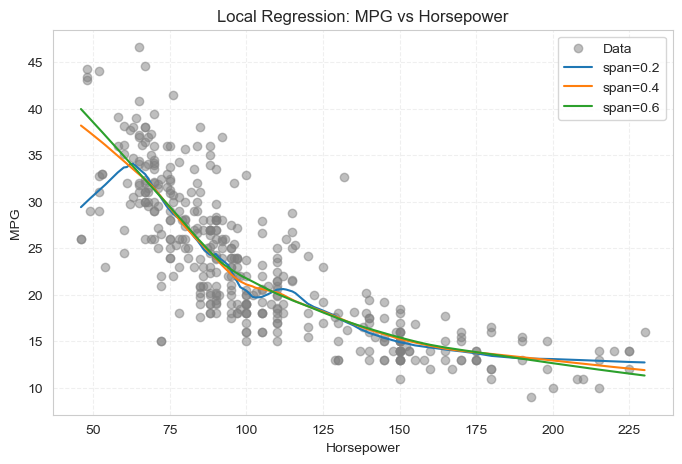

In [100]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(X, y, alpha=0.5, label="Data", color="gray")

# Fit local regression models with different span parameters on the full data:
for span in [0.2, 0.4, 0.6]:
    smoothed = lowess(y, X.flatten(), frac=span)
    plt.plot(smoothed[:, 0], smoothed[:, 1], 
             label=f"span={span}")

ax.set_xlabel("Horsepower")
ax.set_ylabel("MPG")
ax.set_title("Local Regression: MPG vs Horsepower")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.3)